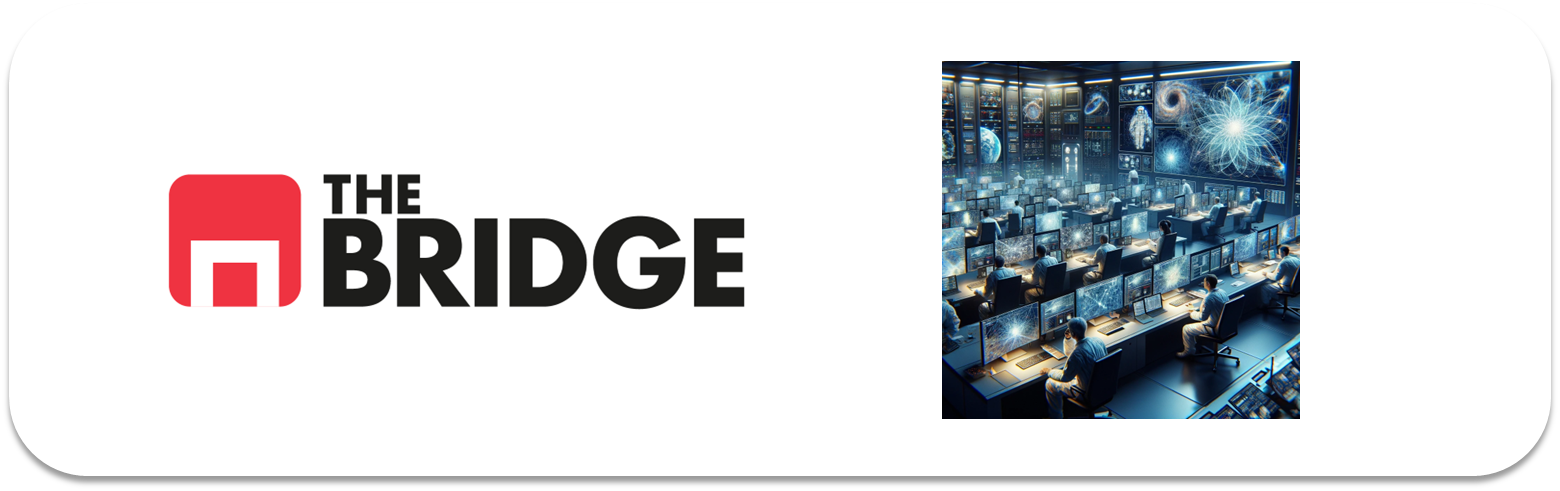

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [22]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models




### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



## #1

In [ ]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + 'seg_train/'
TEST_PATH = ROOT_PATH + 'seg_test/'

In [3]:
IM_SIZE = 64

In [4]:
def read_data(directorio, reshape_dim = (IM_SIZE,IM_SIZE)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a IM_SIZE X IM_SIZE

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [5]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

In [6]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [7]:
def plot_paisajes(paisajes,  labels = [], n_cols = 5,):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2.2))
    if isinstance(paisajes,pd.DataFrame):
        paisajes_val = paisajes.values.reshape(-1,IM_SIZE,IM_SIZE)
    else:
        paisajes_val = paisajes
    for index, paisaje in enumerate(paisajes_val):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje)
        plt.axis("off")
        plt.title(labels[index])
        

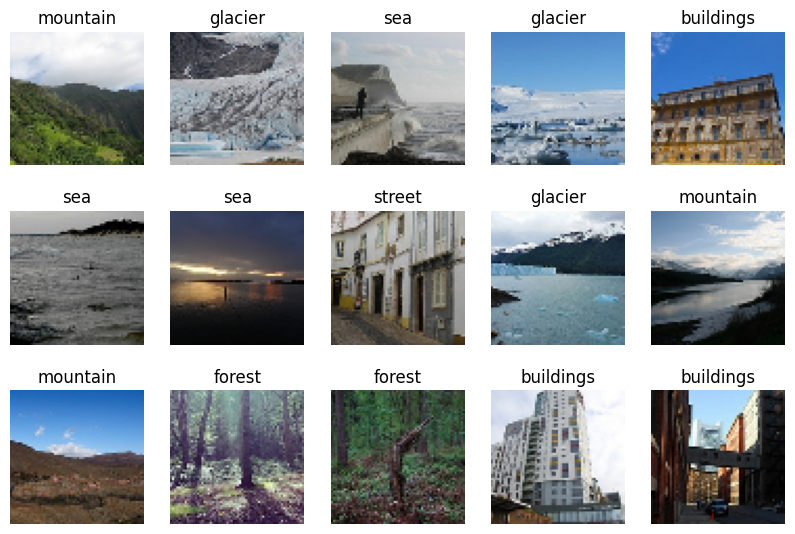

In [8]:
plot_paisajes(X_train[1230:1245], y_train[1230:1245])

Normalizamos las features

In [9]:
X_train =  X_train/255
X_test = X_test/255

In [10]:
X_train.shape

(14034, 64, 64, 3)

In [11]:
y_train

array(['street', 'buildings', 'street', ..., 'street', 'mountain',
       'buildings'], dtype='<U9')

In [12]:
y_train_bck = y_train.copy()

In [13]:
y_train = pd.DataFrame(y_train,columns=['clase'])['clase'].map({'mountain': 0, 'glacier': 1, 'street': 2, 'sea': 3, 'forest': 4, 'buildings': 5})
y_test = pd.DataFrame(y_test,columns=['clase'])['clase'].map({'mountain': 0, 'glacier': 1, 'street': 2, 'sea': 3, 'forest': 4, 'buildings': 5})

In [14]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## #2

Elegimos el modelo VGG-19

In [ ]:
from keras.applications.vgg19 import VGG19

## #3

Cargamos el modelo

In [ ]:
base_model = VGG19(input_shape = (IM_SIZE, IM_SIZE, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')


Congelamos las capas de la VGG

In [16]:
for layer in base_model.layers:
    layer.trainable = False

Y ahora ya sí nuestra modelo "tuneado":

In [17]:
from keras.layers import Flatten, Dense
from keras.layers import Dropout


x = layers.Flatten()(base_model.output)
 
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             

 Total params: 20,550,470 (78.39 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Ahora entrenamos el modelo

In [20]:
vgghist = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    batch_size = 128, # Cantidad de batches en los que divide el epoch
                    epochs = 1)

88/88 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - acc: 0.7743 - loss: 0.6074 - val_acc: 0.8033 - val_loss: 0.5453


In [21]:
model.evaluate(X_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - acc: 0.8211 - loss: 0.5078


[0.5644080638885498, 0.793666660785675]

In [ ]:
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]
print(classification_report(y_test,y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 293ms/step
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       525
           1       0.69      0.80      0.74       553
           2       0.87      0.83      0.85       501
           3       0.80      0.69      0.74       510
           4       0.96      0.90      0.93       474
           5       0.82      0.83      0.82       437

    accuracy                           0.79      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.79      0.80      3000



In [24]:
y_test_label = pd.DataFrame(y_test,columns=['clase'])['clase'].map({0: 'mountain', 1: 'glacier', 2: 'street', 3: 'sea', 4: 'forest', 5: 'buildings'})
y_pred_label = pd.DataFrame(y_pred,columns=['clase'])['clase'].map({0: 'mountain', 1: 'glacier', 2: 'street', 3: 'sea', 4: 'forest', 5: 'buildings'})

print(classification_report(y_test_label,y_pred_label))

              precision    recall  f1-score   support

   buildings       0.82      0.83      0.82       437
      forest       0.96      0.90      0.93       474
     glacier       0.69      0.80      0.74       553
    mountain       0.69      0.74      0.71       525
         sea       0.80      0.69      0.74       510
      street       0.87      0.83      0.85       501

    accuracy                           0.79      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.79      0.80      3000



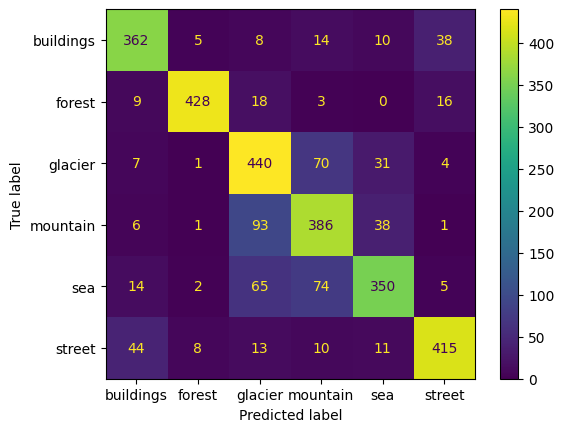

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test_label, y_pred_label)

## #4

In [43]:
base_model_ft = VGG19(input_shape=(IM_SIZE, IM_SIZE,3),
                        include_top=False, # Importante!!
                        weights = None, # Importante!!
                        classifier_activation="softmax")

In [44]:
x = layers.Flatten()(base_model_ft.output)
 
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(6, activation='softmax')(x)

model_ft = tf.keras.models.Model(base_model_ft.input, x)

model_ft.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [45]:
model_ft.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             

 Total params: 20,550,470 (78.39 MB)

 Trainable params: 20,550,470 (78.39 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model_ft.fit(X_train, y_train, validation_split = 0.2, batch_size = 128, epochs = 5) 

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - acc: 0.1742 - loss: 1.8079 - val_acc: 0.1763 - val_loss: 1.7915
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 413s 5s/step - acc: 0.1845 - loss: 1.7910 - val_acc: 0.1763 - val_loss: 1.7915
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 402s 5s/step - acc: 0.1749 - loss: 1.7911 - val_acc: 0.1763 - val_loss: 1.7914
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 404s 5s/step - acc: 0.1773 - loss: 1.7911 - val_acc: 0.1763 - val_loss: 1.7915
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 410s 5s/step - acc: 0.1766 - loss: 1.7905 - val_acc: 0.1763 - val_loss: 1.7916


In [47]:
model_ft.evaluate(X_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 376ms/step - acc: 0.0993 - loss: 1.8176


[1.7900445461273193, 0.17499999701976776]

In [50]:
y_pred = [np.argmax(prediction) for prediction in  model_ft.predict(X_test)]
y_pred_label = pd.DataFrame(y_pred,columns=['clase'])['clase'].map({0: 'mountain', 1: 'glacier', 2: 'street', 3: 'sea', 4: 'forest', 5: 'buildings'})

print(classification_report(y_test_label,y_pred_label))

94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 282ms/step
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.17      1.00      0.30       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.17      3000
   macro avg       0.03      0.17      0.05      3000
weighted avg       0.03      0.17      0.05      3000



C:\Users\josea\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\josea\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\josea\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

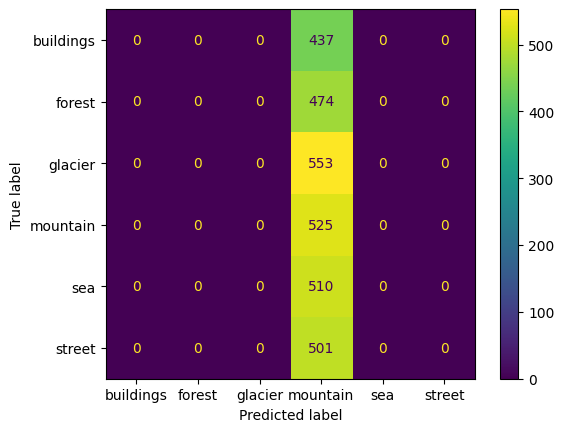

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test_label, y_pred_label)